## <span style="color: #3A6D8C;">Estimating the Power Spectral Density of Ambient Seismic noise

In [19]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from scipy.signal import welch, savgol_filter
from scipy.fft import fft,fftfreq,fftshift
from pathlib import PurePath,Path
from obspy import read, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException

writh_output = True
plt.rcParams.update({'font.size':14})
# plt.rcParams['axes.labelweight'] = 'bold'

##### LHZ component record by MSEY station from network II across the span of 4 days from 2018-07-29 to 08-02


In [2]:
client = Client('IRIS')
starttime = UTCDateTime("2018-07-29T00:00:00")
endtime = UTCDateTime("2018-08-02T00:00:00")
network = "IU"
station = "KIP"
location = "00"
channel = "LHZ"
inv = client.get_stations(
    starttime=starttime,
    endtime=endtime,
    network=network,
    station="*",
    location=location, 
    channel=channel,
    level='response',
)

In [5]:
# define seismic provider
client = Client('IRIS')

# assign data information
starttime = UTCDateTime("2018-07-29T00:00:00")
endtime = UTCDateTime("2018-08-02T00:00:00")
network = "II"
station = "MSEY"
location = "00"
channel = "LHZ" # B:Broadband,H: high quality, L: long period,S:short period, Z: vertical component

# get station inventory data
inv = client.get_stations(
    starttime=starttime,
    endtime=endtime,
    network=network,
    station=station,
    location=location, 
    channel=channel,
    level='response',
)

# storage records 
folder_output = Path.cwd().joinpath('events')
if not folder_output.exists():
    folder_output.mkdir(parents=True)

filename = '{0}-{1}-{2}-{3}-{4:04s}-{5:04s}'.format(network, station, location, channel, starttime.strftime("%Y-%m-%d"),endtime.strftime("%m-%d"))

if not any(folder_output.glob(filename + '.*')):
    try:
        st = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            starttime=starttime,
            endtime=endtime,
            channel=channel,
        )

        tr = st[0].copy()
        tr.detrend('demean')
        tr.detrend('linear')
        pre_filt = (0.005, 0.006, 0.5,0.8)
        tr.remove_response(inventory=inv, output="VEL", water_level=60, pre_filt=pre_filt)
        tr.taper(0.01)
        if writh_output:
            tr.write(folder_output.joinpath(filename+'.SAC').as_posix(), format="SAC")

    except FDSNNoDataException() as e:
        print('opps,{0:}'.format(e))
    
else:
    st = read(folder_output.joinpath(filename+'.SAC').as_posix(), format="SAC")
    tr = st[0].copy() 
    tr.data = tr.data * 1e6 # value too small may induce compute error
    

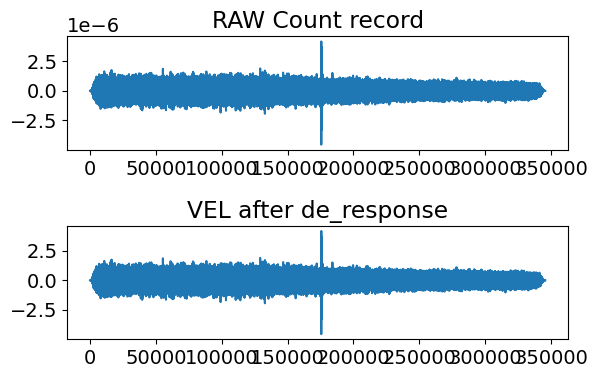

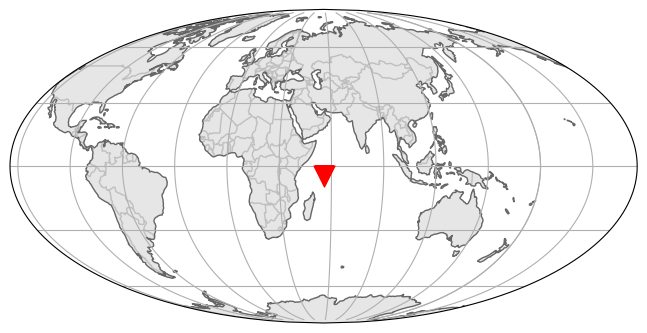

In [6]:
fig, ax = plt.subplots(2,1,figsize=(6,4))
ax[0].plot(tr.times(type="relative"), st[0].data)
ax[1].plot(tr.times(type="relative"), tr.data)


ax[0].set_title('RAW Count record')
ax[1].set_title('VEL after de_response')
plt.tight_layout()
inv.plot(projection='global',
         resolution='c',
         color="red",
         label=False,)

plt.show()

### <span style="color: #D76C82">Several method to estimate power signal spectrum
In general, PSD directly derived by $\frac{1}{N}|F(k)|^{2}$ and Spectrum only calculate $|F(k)|^{2}$

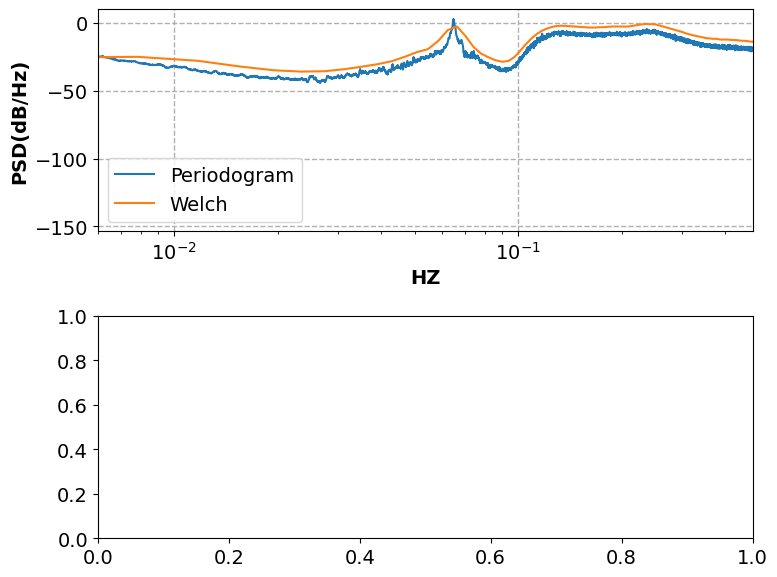

In [24]:
# periodogram
dt = tr.stats.delta
fs = tr.stats.sampling_rate
npts = tr.stats.npts
fft_tr = fft(tr.data)
freq = fftfreq(npts,dt)[:npts // 2]
periodogram = 10 * np.log10(abs(fft_tr)**2 / npts)[:npts // 2] # why we use relative amplitude? we know the authentic vaule of amp equals abs(fft)/N

# welch
nperseg = 2**8
f2, p2 = welch(tr.data, fs, nperseg=nperseg, noverlap=nperseg//4) # return one-side spectrum by default
welch_psd = 10 * np.log10(p2)

# Savitzky-golay filter smoothing
periodogram = savgol_filter(periodogram, 256, 2)
welch_psd = savgol_filter(welch_psd, 5, 2)

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax[0].semilogx(freq, periodogram, label='Periodogram')
ax[0].semilogx(f2, welch_psd, label='Welch')
ax[0].set_xlim([6e-3, fs*0.48])
ax[0].legend()
ax[0].set_xlabel('HZ')
ax[0].set_ylabel('PSD(dB/Hz)')
ax[0].grid(lw=1, linestyle='--')
plt.tight_layout()
